<a href="https://colab.research.google.com/github/AshkanGanj/Pneumonia-Detection--X-Ray--CNN/blob/main/X_Ray_Pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'username' # enter your kaggle username
os.environ['KAGGLE_KEY'] = 'key' # enter your kaggle key
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 23.4MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.8MB/s]


**Unzip downloaded file**

In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### **Import all required packages**

In [ ]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau


### Write a function to load data from the desired path

In [ ]:
labels = ['PENUMONIA','NORMAL']
imagesize = 150
def load_data(data_path):
  data = []
  for label in labels:
    print(label)
    path = os.path.join(data_path, label)
    print(path)
    for img in os.listdir(path):
        try:
            imgArr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resizedArr = cv2.resize(imgArr, (imageSize, imageSize)) # Reshaping images to preferred size
            data.append([resizedArr, classNum])
        except Exception as e:
            print(e)

### load data

Load all 3 groups, which are train, validation, and test.

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
imageSize = 150
class DataManagement:
  def loadData(self,dataDir):
    data = []
    for label in labels: 
        path = os.path.join(dataDir, label)
        classNum = labels.index(label)
        print(path)
        for img in os.listdir(path):
            try:
                imgArr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resizedArr = cv2.resize(imgArr, (imageSize, imageSize)) # Reshaping images to preferred size
                data.append([resizedArr, classNum])
            except Exception as e:
                print(e)
    return np.array(data)

  def getTrainData(self):
    return self.loadData('/content/chest_xray/train')

  def getValidationData(self):
    return self.loadData('/content/chest_xray/val')

  def getTestData(self):
    return self.loadData('/content/chest_xray/test')


In [ ]:
DATA = DataManagement()

train = DATA.getTrainData()
test = DATA.getTestData()
val = DATA.getValidationData()

/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL


### Data Visualization & Preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


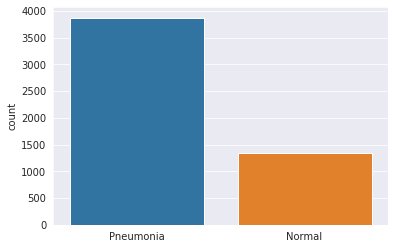

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(l)

As we can see, we can see Data is imbalanced. 
To fix this problem, we should increase our dataset size with the help of data augmentation.

### Previewing the images of both the classes

Text(0.5, 1.0, 'NORMAL')

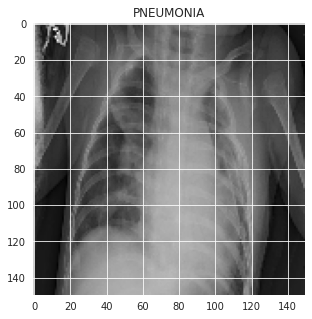

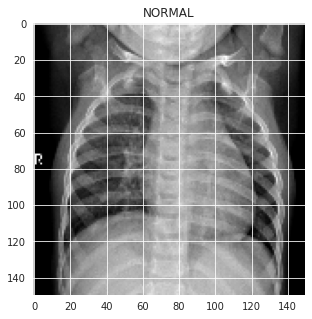

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
xTrain = []
yTrain = []

xVal = []
yVal = []

xTest = []
yTest = []

for feature, label in train:
    xTrain.append(feature)
    yTrain.append(label)

for feature, label in test:
    xTest.append(feature)
    yTest.append(label)
    
for feature, label in val:
    xVal.append(feature)
    yVal.append(label)

### Normalize our data 
we limit our data ranges between 0 and 1 to help the model converge faster.

In [ ]:
# Normalize the data
xTrain = np.array(xTrain) / 255
xVal = np.array(xVal) / 255
xTest = np.array(xTest) / 255

In [ ]:
# resize data for deep learning 
xTrain = xTrain.reshape(-1, imageSize, imageSize, 1)
yTrain = np.array(yTrain)

xVal = xVal.reshape(-1, imageSize, imageSize, 1)
yVal = np.array(yVal)

xTest = xTest.reshape(-1, imageSize, imageSize, 1)
yTest = np.array(yTest)

In [ ]:
print(xTrain.shape)

(5216, 150, 150, 1)


# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(xTrain)

For the data augmentation, i choosed to :



1.  Randomly rotate some training images by 30 degrees
2.  Randomly Zoom by 20% some training images
3.  Randomly shift images horizontally by 10% of the width
4.  Randomly shift images vertically by 10% of the height
5.  Randomly flip images horizontally. Once our model is ready, we fit the 6. 6.training dataset.





### create our model

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))


### compile our model and get a summary

In [ ]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [ ]:
history = model.fit(datagen.flow(xTrain,yTrain, batch_size = 32) ,epochs =12 , validation_data = datagen.flow(xVal, yVal),callbacks = [learning_rate_reduction])

# Train the model
# history = model.fit(
#     xTrain,
#     yTrain,
#     batch_size=128,
#     epochs=20,
#     validation_data=(xVal, yVal),
#     shuffle=True,
# )

Epoch 1/12
163/163 [==============================] - 11s 70ms/step - loss: 0.0768 - accuracy: 0.9757 - val_loss: 0.9710 - val_accuracy: 0.6875
Epoch 2/12
163/163 [==============================] - 12s 71ms/step - loss: 0.0744 - accuracy: 0.9766 - val_loss: 0.7534 - val_accuracy: 0.6875
Epoch 3/12
163/163 [==============================] - 12s 72ms/step - loss: 0.0696 - accuracy: 0.9762 - val_loss: 0.6537 - val_accuracy: 0.7500
Epoch 4/12
163/163 [==============================] - 11s 70ms/step - loss: 0.0644 - accuracy: 0.9768 - val_loss: 0.6663 - val_accuracy: 0.6875
Epoch 5/12
163/163 [==============================] - 11s 66ms/step - loss: 0.0727 - accuracy: 0.9764 - val_loss: 0.7680 - val_accuracy: 0.6875
Epoch 6/12
163/163 [==============================] - 11s 65ms/step - loss: 0.0651 - accuracy: 0.9785 - val_loss: 0.7629 - val_accuracy: 0.6250
Epoch 7/12
163/163 [==============================] - 11s 65ms/step - loss: 0.0806 - accuracy: 0.9757 - val_loss: 0.8245 - val_accuracy:

In [ ]:
print("Loss of the model is - " , model.evaluate(xTest,yTest)[0])
print("Accuracy of the model is - " , model.evaluate(xTest,yTest)[1]*100 , "%")

20/20 [==============================] - 0s 14ms/step - loss: 0.2578 - accuracy: 0.9135
Loss of the model is -  0.25784581899642944
20/20 [==============================] - 0s 13ms/step - loss: 0.2578 - accuracy: 0.9135
Accuracy of the model is -  91.34615659713745 %


Text(0, 0.5, 'Training & Validation Loss')

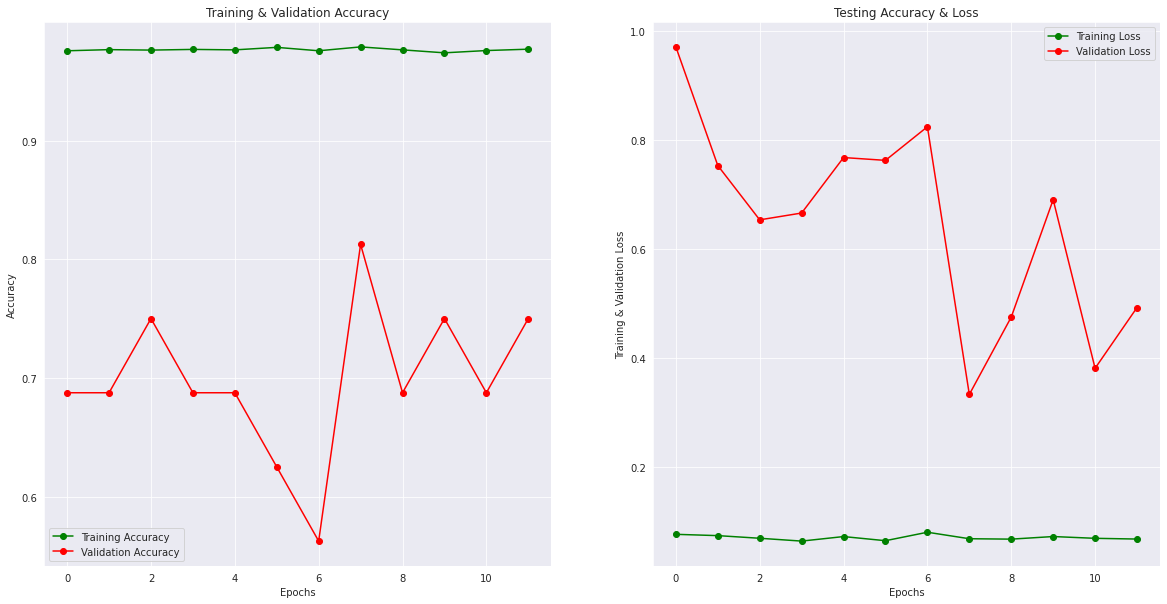

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")

# plt.show()
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [ ]:
predictions = model.predict_classes(xTest)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
correct = np.nonzero(predictions == yTest)[0]
incorrect = np.nonzero(predictions != yTest)[0]

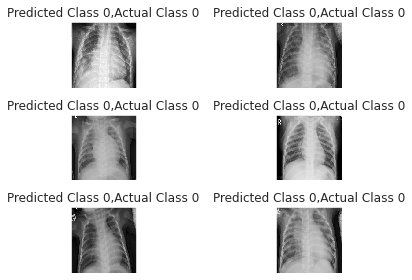

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(xTest[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], yTest[c]))
    plt.tight_layout()
    i += 1

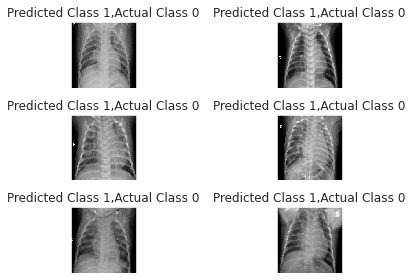

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(xTest[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], yTest[c]))
    plt.tight_layout()
    i += 1